# Milestone 3

**Data Source**

The Google Local Data (2021) offers a comprehensive collection from Google Local (Google Maps), featuring 65,000 restaurants and over 1.77 million reviews, along with 4.43 million images posted by approximately 1.01 million users. It contains detailed information such as geographical location, business category,
opening status, price levels, and average ratings for each restaurant. This multi-modal dataset
includes textual reviews, user-generated images, and various metadata attributes, providing a
comprehensive foundation for analyzing consumer preferences and behaviors in the context of
restaurant recommendations.

For our project, we decided to focus on the resturants in Massachusetts, which includes 5,624,944 reviews and 92,520 businesses in metadata.

*Massachusetts 10-cores Review Dataset*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

*Masechusetts Metadata*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

In [9]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
review_ma = pd.read_json('data/review-Massachusetts_10.json', lines=True)
metadata_ma = pd.read_json('data/meta-Massachusetts.json', lines=True)

# Filter out restaurants based on business category
restaurant_ma = metadata_ma[metadata_ma['category'].apply(lambda x: 'Restaurant' in x if isinstance(x, list) else False)]

# Drop duplicated rows
review_ma = review_ma.drop_duplicates(subset=['user_id', 'name', 'time', 'rating', 'text', 'gmap_id'])
restaurant_ma = restaurant_ma.drop_duplicates(subset = ["name", "address", "gmap_id", "url"])

df = pd.merge(review_ma, restaurant_ma, on='gmap_id', how='inner')
df.to_csv("data/data_ma.csv", index=False)
print("Number of restaurant reviews in MA:", len(df))

Number of restaurant reviews in MA: 1239217


Since the complete Massachusetts review data is 3.03GB and even reading the file takes too long, we use the reduced **10-core review data** (1.44GB). We think this is reasonable because it ensures a **sufficient level of interaction data** for each entity, enabling more reliable and robust analysis or model training.

We also narrow down the **metadata** to include only entities classified as restaurants, ensuring we consider only relevant businesses. 

We then merge this filtered metadata with the review data based on the gmap_id field, which acts as a common identifier between the two datasets, using an inner join. The result is saved as a CSV file, creating a dataset that is more manageable in size and more focused for analysis or model training, containing over 1.25 million reviews of restaurants in Massachusetts.

## Summary of the Data

In [2]:
df = pd.read_csv("data/data_ma.csv")
df.count()

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_61284/244506563.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


user_id             1239217
name_x              1239208
time                1239217
rating              1239217
text                 646018
pics                  38179
resp                  90414
gmap_id             1239217
name_y              1239217
address             1238788
description         1060076
latitude            1239217
longitude           1239217
category            1239217
avg_rating          1239217
num_of_reviews      1239217
price               1130401
hours               1209664
MISC                1231978
state                626554
relative_results    1226787
url                 1239217
dtype: int64

In [3]:
print(df.dtypes)
n_users = df['user_id'].nunique()
n_rest = df['gmap_id'].nunique()
print("Number of Users: {}".format(n_users))
print("Number of Restaurants: {}".format(n_rest))

user_id             float64
name_x               object
time                  int64
rating                int64
text                 object
pics                 object
resp                 object
gmap_id              object
name_y               object
address              object
description          object
latitude            float64
longitude           float64
category             object
avg_rating          float64
num_of_reviews        int64
price                object
hours                object
MISC                 object
state                object
relative_results     object
url                  object
dtype: object
Number of Users: 188265
Number of Restaurants: 5893


Our merged dataset comprises 1,253,377 observations and 22 columns, with reviews from 188,265 distinct users for 5,893 different restaurants. For our upcoming NLP tasks, we plan to consider the following features:

* `user_id`: The ID of the user (categorical variable)
* `rating`: The rating given by a user to a restaurant (numerical)
* `text`: The review text (textual data)
* `gmap_id`: The ID of the restaurant (categorical variable)
* `latitude`: The latitude of the restaurant (numerical)
* `longitude`: The longitude of the restaurant (numerical)
* `num_of_reviews`: The number of reviews for a restaurant (numerical)
* `price`: The price index of the restaurant, ranging from $ to $$$$ (categorical variable)

## Data Analysis & Visualization

In [7]:
print(f"Percentage of missing review text: {df['text'].isna().sum()/len(df)*100:.2f}%")
print(f"Percentage of reviews with missing values in 'price' column: {df['price'].isna().sum()/len(df)*100:.2f}%")

Percentage of missing review text: 47.87%
Percentage of reviews with missing values in 'price' column: 8.78%


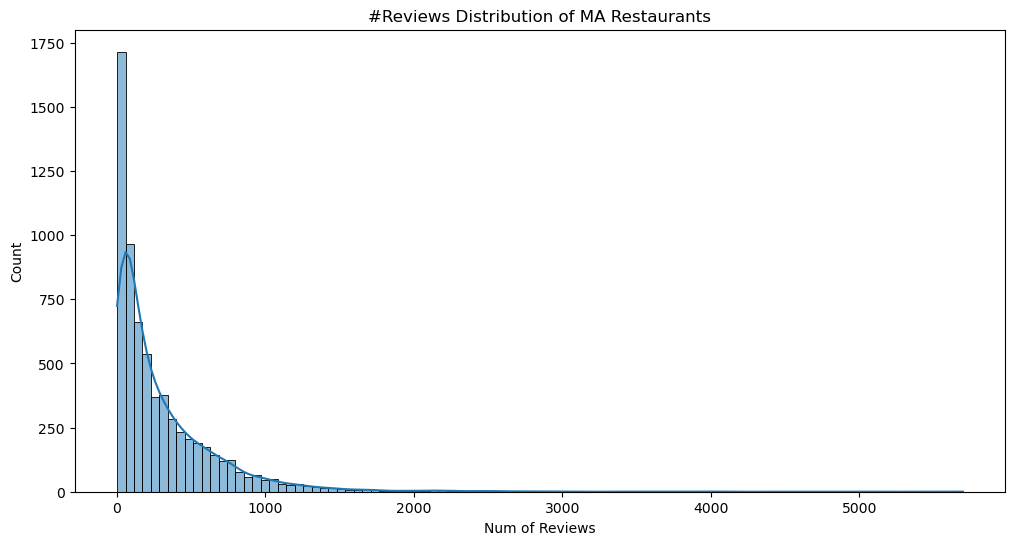

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(restaurant_ma['num_of_reviews'], bins=100, kde=True)
plt.title('#Reviews Distribution of MA Restaurants')
plt.xlabel('Num of Reviews')
plt.ylabel('Count')
plt.show()

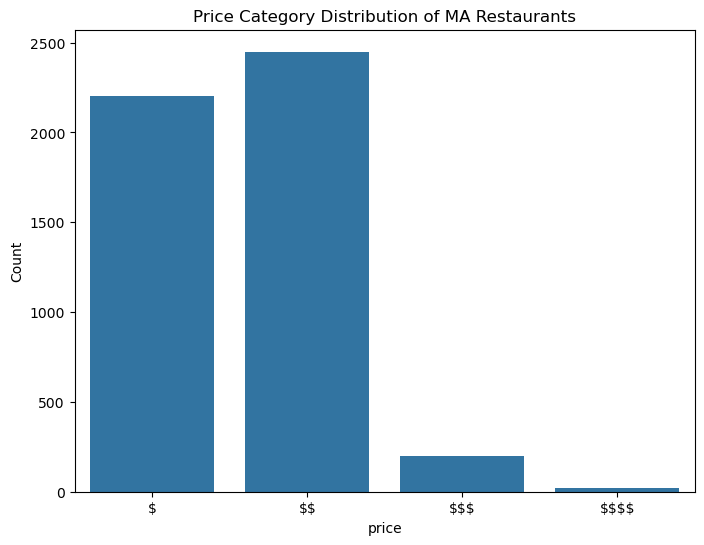

In [11]:
plt.figure(figsize=(8, 6))

valid_prices = restaurant_ma['price'].dropna().astype(str)
price_lengths = valid_prices.apply(len)

sns.countplot(x=price_lengths)
plt.title('Price Category Distribution of MA Restaurants')
xticklabels = [r'{}'.format('\$' * p) for p in sorted(price_lengths.unique())]
plt.xticks(range(len(xticklabels)), xticklabels) 
plt.ylabel('Count')
plt.show()

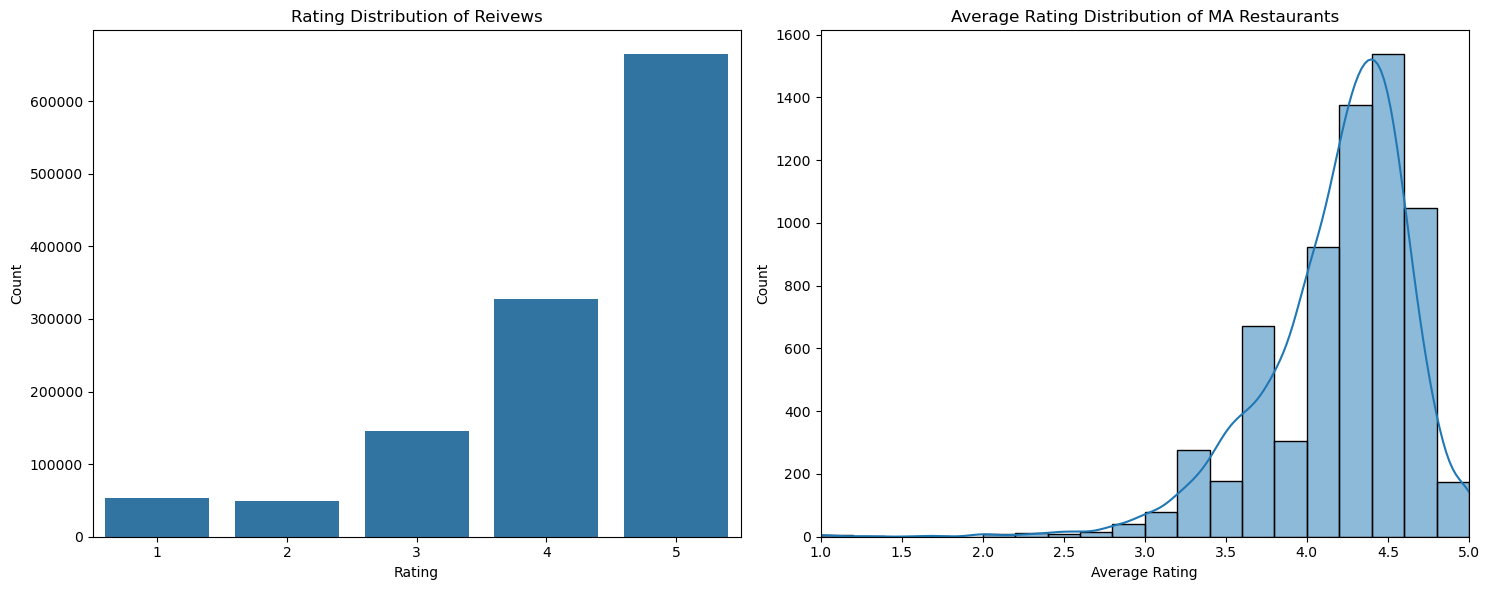

In [12]:
# Visualize Rating Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Review Rating Distribution
sns.countplot(x='rating', data=df, ax=axes[0])
axes[0].set_title('Rating Distribution of Reivews')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Plot Average Rating of Restaurants
sns.histplot(restaurant_ma['avg_rating'], ax=axes[1], bins=20, kde=True)
axes[1].set_title('Average Rating Distribution of MA Restaurants')
axes[1].set_xlabel('Average Rating')
axes[1].set_xlim([1,5])
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Natural Lanugage Processing

In [17]:
import json
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams, trigrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
all_text = df[-df['text'].isna()].drop_duplicates(subset='text', keep='first').text.to_list()

with open('data/reviews.json', 'w', encoding='utf-8') as file:
    json.dump(all_text, file, ensure_ascii=False, indent=2)

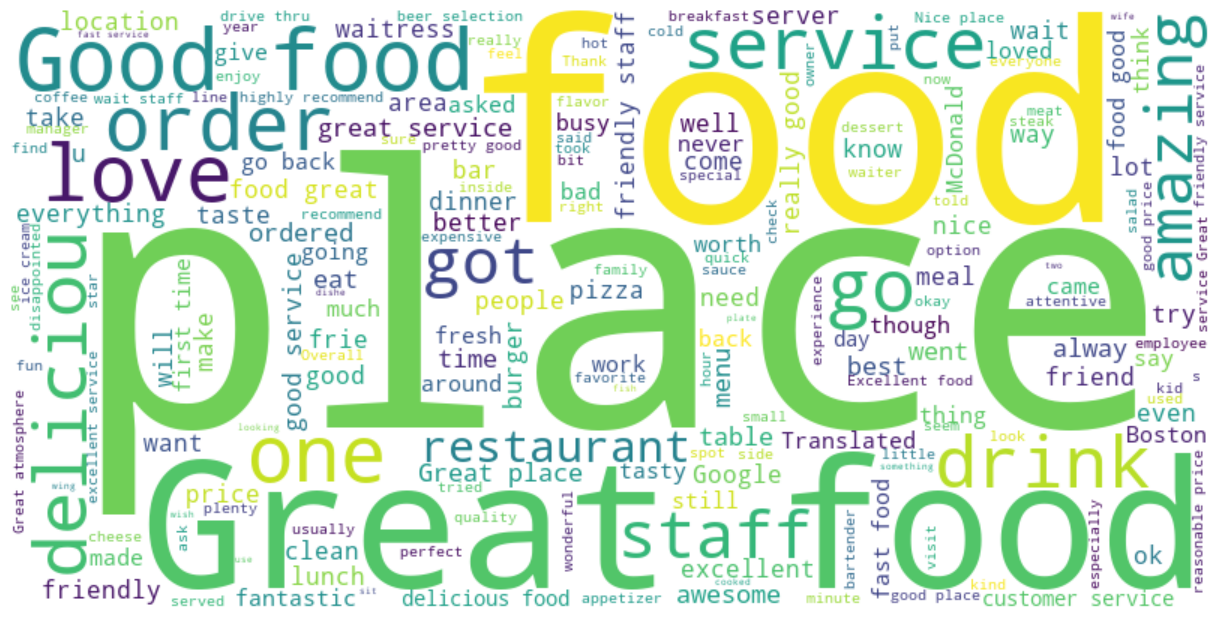

In [19]:
all_text = pd.read_json('data/reviews.json').iloc[:,0].tolist()

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_text))

# Display the word cloud using matplotlib
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [20]:
tokens = [word_tokenize(text.lower()) for text in all_text]
flat_tokens = [item for sublist in tokens for item in sublist]

# Compute the frequency distribution of the words
freq_dist = FreqDist(flat_tokens)

# Display the most common words
pd.DataFrame(freq_dist.most_common(15), columns=['Word', 'Frequency'])

,Word,Frequency
0,.,958223
1,the,632500
2,and,493926
3,",",439262
4,a,318824
5,food,265824
6,was,258912
7,i,253714
8,to,247448
9,!,240203


In [21]:
# Generate bigrams from the flattened list of tokens
bigram_freq = FreqDist(bigrams(flat_tokens))

pd.DataFrame(bigram_freq.most_common(15), columns=['Bigram', 'Frequency'])

,Bigram,Frequency
0,"(., the)",103167
1,"(., i)",79836
2,"(!, !)",60064
3,"(the, food)",56378
4,"(and, the)",49377
5,"(., great)",46247
6,"(,, and)",44506
7,"(food, was)",39200
8,"(,, but)",38182
9,"(it, was)",36392


#### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=6000) 

tfidf_embeddings = vectorizer.fit_transform(all_text)

## Topic Analysis

In [22]:
df_clean = df[['user_id','name_y','gmap_id','num_of_reviews','latitude','longitude','price','rating','avg_rating','text']].sort_values(by=['user_id', 'gmap_id'])
df_clean = df_clean.dropna()
df_clean = df_clean[~df_clean['price'].isin(['₩₩','₩','₩₩₩'])]
one_hot = pd.get_dummies(df_clean['price'])
df_clean = pd.concat([df_clean, one_hot], axis=1)
df_clean.head(3)

,user_id,name_y,gmap_id,num_of_reviews,latitude,longitude,price,rating,avg_rating,text,$,$$,$$$,$$$$
837777,1.000001e+20,Wendy's,0x89e3795251fd454b:0x4f01d3736bcdfa3e,1938,42.287219,-71.106579,$,3,3.5,Long lines at the drive through. Takes a long ...,True,False,False,False
449417,1.000001e+20,Lincoln Tavern & Restaurant,0x89e37a8987d440e9:0x89c8b6df7d92e4f7,1292,42.336315,-71.047597,$$,4,4.4,I love the food but parking is horrible. I had...,False,True,False,False
902926,1.000002e+20,Lord Hobo Cambridge,0x89e370b2901c3261:0xe57850ab0b46d7a1,1078,42.368725,-71.094955,$$,4,4.4,The food is good for Boston but nothing to rav...,False,True,False,False


In [24]:
# combine the review text for each rating
df_by_rating = df_clean[['gmap_id', 'price', 'rating','user_id', 'text']]
df_rating_combined = df_by_rating.groupby('rating')['text'].apply(' '.join).reset_index()
df_rating_combined ['text'] = df_rating_combined ['text'].str.replace(r'\(Original\)', '', regex=True)
df_rating_combined ['text'] = df_rating_combined ['text'].str.replace(r'\(Translated by Google\)', '', regex=True)

df_rating_combined.head()

,rating,text
0,1,"First time at this establishment, I have to sa..."
1,2,I am a native and hate to say it. But you dont...
2,3,Long lines at the drive through. Takes a long ...
3,4,I love the food but parking is horrible. I had...
4,5,"Tasty and interesting food, beautiful patio, g..."


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


stopwords = stopwords.words('english')
bow_vectorizer = CountVectorizer(stop_words=stopwords, lowercase=True)

# Iterate over each price group
for rating, group in df_rating_combined.groupby('rating'):
    print(f"Topics for Rating: {rating}")
    
    # Vectorize the text for the current price group
    bow_matrix = bow_vectorizer.fit_transform(group['text'].values.tolist())
    
    # Fit LDA model
    lda_bow = LDA(n_components=3, random_state=42)
    lda_bow.fit(bow_matrix)

    # Print the top words for each topic
    for idx, topic in enumerate(lda_bow.components_):
        print(f"Top words in Topic #{idx}:")
        print([bow_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-7:]])
    print('')


Topics for Rating: 1
Top words in Topic #0:
['never', 'get', 'time', 'place', 'order', 'service', 'food']
Top words in Topic #1:
['nausia', 'navigated', 'navy', 'nb', 'nba', 'nationwide', '흔히들']
Top words in Topic #2:
['nausia', 'navigated', 'navy', 'nb', 'nba', 'nationwide', '흔히들']

Topics for Rating: 2
Top words in Topic #0:
['time', 'like', 'order', 'place', 'good', 'service', 'food']
Top words in Topic #1:
['nighr', 'nightclub', 'comigo', 'nightstand', 'niiiice', 'nicolle', '했더니']
Top words in Topic #2:
['nighr', 'nightclub', 'comigo', 'nightstand', 'niiiice', 'nicolle', '했더니']

Topics for Rating: 3
Top words in Topic #0:
['katsumen', 'katchup', 'katau', 'kat', 'kashk', 'kauhog', '𝓷𝓮𝓮𝓭']
Top words in Topic #1:
['like', 'ok', 'great', 'place', 'service', 'good', 'food']
Top words in Topic #2:
['katsumen', 'katchup', 'katau', 'kat', 'kashk', 'kauhog', '𝓷𝓮𝓮𝓭']

Topics for Rating: 4
Top words in Topic #0:
['jumbled', 'jumbalia', 'jumbalaya', 'julliene', 'julienned', 'juju', '흥겹고']
Top 

## Meaningful Insights

### Missingness
Having 660,100 rows with review text is indeed a substantial amount of data for our subsequent NLP tasks. It's important to note that text data is inherently qualitative and context-dependent, making it challenging to accurately impute missing values. Therefore, it's reasonable to proceed with non-null review text when incorporating NLP techniques

While location can be a factor in determining the price range of a restaurant, it's not the sole determinant. Other factors such as the quality of food, ambiance, service, and overall reputation also play significant roles. Therefore, our first thought of imputing the missing price indicators solely based on longitude and latitude may not accurately reflect the true price range of the restaurants.

With only 8.76% of reviews having missing values in the 'price' column, the overall impact on the analysis may be limited.

Instead of imputing missing price indicators, an alternative approach could be to incorporate the price information directly into the text data. By concatenating the price indicator into the review text, such as **"the price is '$$$'"**, we can ensure that this information is captured and utilized in subsequent analyses.

### Data Imbalance
From the plots above, we can see that the rating distribution is left-skewed, meaning that a majority of reviewers give higher ratings. The price index distribution is predominantly concentrated around \$ and \$$, indicating that more reviews are available for restaurants in the affordable price range. While there is some imbalance in the dataset, it is not a significant concern for this project, which aims to construct a restaurant recommendation system based on review text rather than performing classification tasks.

### Feature Scaling 
In this project, we will not apply feature scaling to our numerical features, including latitude, longitude, and ratings to maintain the interpretability of our recommendation system.

### Word Count
The most common words are stop words, which usually don't contribute to the sentiment or topic of a review. For deeper analysis, these should be filtered out to focus on more meaningful words. For puncatuation marks, exclamation points might signify strong feelings that could be important for sentiment analysis.

### Topic Analysis
We conducted topic analysis for review texts by different ratings, hoping to capture what aspects of restaurants are important for customers for them to give high ratings in order to gain some insights about our recommondation system. The topic analysis using TF-IDF reveals more informative results than the one using count vector. We can tell that while the higher ratiing seems to have more positive words in their top topics, and that service/food/place are top words in multiple top topics for different ratings, suggesting that service/food/place are indeed important aspects for customers and thus are useful for our recommondation system.

## Revised Project Question

Based on the data's characteristics and the preliminary analysis outlined, a potential project question could revolve around understanding how different factors influence consumer ratings and preferences towards restaurants in Massachusetts. More specifically, our project question would be : **How can we leverage natural language processing and sentiment analysis to understand the impact of geographical location, price levels, and review volumes on consumer ratings of restaurants in Massachusetts, and how can this understanding be applied to develop a recommendation system that matches users with restaurants based on their preferences and dining history?**

This question aims to apply the initial analysis of factors influencing consumer ratings with the development of a practical application that improves user experience by personalizing restaurant recommendations. It encapsulates a holistic approach to the data, leveraging insights from the EDA to inform the design and functionality of a recommendation system. This comprehensive question sets the stage for a project that not only uncovers insights through data analysis but also applies these insights in a manner that directly benefits users by enhancing their dining experiences.

# Baseline Model

Due to the limited number of user-restaurant pairs available for calculating similarities between users, our attempts to employ item collaborative filtering for recommendation have proven ineffective. To address this challenge in the next iteration of our model, we intend to incorporate textual information into the similarity computation process. Additionally, we plan to extract a subset of the data containing denser user-restaurant pairings. This subset will provide us with more meaningful data points to leverage similarities between users for recommendation purposes. Moreover, reducing the dimensionality of the data will help streamline the NLP task, making it less time-consuming.

In [4]:
df_clean = df[['user_id','name_y','gmap_id','num_of_reviews','latitude','longitude','price','rating','avg_rating','text']].sort_values(by=['user_id', 'gmap_id'])
df_clean = df_clean.dropna()
df_clean = df_clean[~df_clean['price'].isin(['₩₩','₩','₩₩₩'])]
one_hot = pd.get_dummies(df_clean['price'])
df_clean = pd.concat([df_clean, one_hot], axis=1)
df_clean.head()

,user_id,name_y,gmap_id,num_of_reviews,latitude,longitude,price,rating,avg_rating,text,$,$$,$$$,$$$$
837777,1.000001e+20,Wendy's,0x89e3795251fd454b:0x4f01d3736bcdfa3e,1938,42.287219,-71.106579,$,3,3.5,Long lines at the drive through. Takes a long ...,True,False,False,False
449417,1.000001e+20,Lincoln Tavern & Restaurant,0x89e37a8987d440e9:0x89c8b6df7d92e4f7,1292,42.336315,-71.047597,$$,4,4.4,I love the food but parking is horrible. I had...,False,True,False,False
902926,1.000002e+20,Lord Hobo Cambridge,0x89e370b2901c3261:0xe57850ab0b46d7a1,1078,42.368725,-71.094955,$$,4,4.4,The food is good for Boston but nothing to rav...,False,True,False,False
1213600,1.000002e+20,Oleana,0x89e370b2d41372af:0xae84228b09fd944f,1098,42.370549,-71.097186,$$$,5,4.7,"Tasty and interesting food, beautiful patio, g...",False,False,True,False
654520,1.000002e+20,Hokkaido Ramen Santouka Harvard Square,0x89e37743508533dd:0x4243a046d8931294,2028,42.372129,-71.115887,$$,4,4.5,Simple but tasty ramen,False,True,False,False


In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589985 entries, 845470 to 399904
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         589985 non-null  float64
 1   name_y          589985 non-null  object 
 2   gmap_id         589985 non-null  object 
 3   num_of_reviews  589985 non-null  int64  
 4   latitude        589985 non-null  float64
 5   longitude       589985 non-null  float64
 6   price           589985 non-null  object 
 7   rating          589985 non-null  int64  
 8   avg_rating      589985 non-null  float64
 9   text            589985 non-null  object 
 10  $               589985 non-null  bool   
 11  $$              589985 non-null  bool   
 12  $$$             589985 non-null  bool   
 13  $$$$            589985 non-null  bool   
dtypes: bool(4), float64(4), int64(2), object(4)
memory usage: 51.8+ MB


In [5]:
sampled_df = df_clean.sample(frac=0.1, random_state=42)
sampled_df

,user_id,name_y,gmap_id,num_of_reviews,latitude,longitude,price,rating,avg_rating,text,$,$$,$$$,$$$$
1122162,1.038063e+20,McDonald's,0x89e307a27e4aee3f:0x7845b9d47634b94a,1117,42.705037,-71.168723,$,2,3.6,Food very oily,True,False,False,False
953557,1.021010e+20,QDOBA Mexican Eats,0x89e37a18b6de39df:0x5d3e6750e76e4f4c,794,42.339767,-71.090901,$,5,4.2,"Never been to a Qdoba before, and I must say I...",True,False,False,False
593861,1.085886e+20,Thornton's,0x89e37a11b08c434f:0x43f53b4de61866a2,803,42.344979,-71.081884,$,5,4.3,Great breakfast spot. Great prices and portions,True,False,False,False
1244027,1.126265e+20,Brax Landing Restaurant,0x89fb3fb5753283ad:0xf94514a243ef4d55,1104,41.669767,-70.060278,$$,5,4.4,"View, frozen drinks, and food are all amazing....",False,True,False,False
787762,1.049673e+20,Antonio’s Pizza By The Slice Kitchen & Bar - W...,0x89e4069066fb8a77:0x33fed476069e1b94,1695,42.261697,-71.822694,$,5,4.4,"Great food, you can get pizza by the slice if ...",True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088340,1.060297e+20,Stoddard's Fine Food & Ale,0x89e3709d2b27958b:0x40a0e32c1d5f2a20,908,42.355130,-71.061709,$$,3,4.2,Good variety of beers. Very large food portion...,False,True,False,False
873202,1.019863e+20,The Cheesecake Factory,0x89e37d3dfc14dd9d:0xaff6351f245e33e2,2158,42.222048,-71.024890,$$,5,4.1,Great place,False,True,False,False
1183877,1.124222e+20,Popeyes Louisiana Kitchen,0x89e6dd550f1af1d7:0xefa746157422fbc8,1054,42.134685,-72.523380,$,5,3.6,Love their shrimp,True,False,False,False
1106955,1.020069e+20,TGI Fridays,0x89e3711836b33e07:0xe54c9c389f21ed5f,1155,42.400834,-71.068765,$$,5,3.5,(Translated by Google) It takes longer is good...,False,True,False,False


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sampled_df.drop(['rating','text','name_y','price','user_id','gmap_id'], axis=1), 
                                                    sampled_df[['rating']], 
                                                    test_size=0.3, random_state = 42)
X_train

,num_of_reviews,latitude,longitude,avg_rating,$,$$,$$$,$$$$
987446,981,42.418118,-71.108858,4.6,True,False,False,False
1141236,1370,42.135345,-72.625044,4.0,False,True,False,False
1096462,177,42.368292,-71.076520,3.7,True,False,False,False
238824,283,42.557766,-70.878878,3.8,False,True,False,False
1231115,3464,42.353665,-71.048757,4.2,False,True,False,False
...,...,...,...,...,...,...,...,...
99054,115,42.770130,-71.075183,4.0,True,False,False,False
1173662,1988,42.350297,-71.038247,4.0,False,True,False,False
458025,188,42.103903,-72.635381,4.4,True,False,False,False
293417,166,42.296031,-71.087197,4.0,True,False,False,False


In [10]:
import xgboost as xgb
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
pred1 = model1.predict(X_test)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

content-based rmse = 1.2272550129399729


In [12]:
sampled_df.groupby(['gmap_id', 'user_id']).size().reset_index(name='count')

,gmap_id,user_id,count
0,0x405c5a74b3440383:0xa36c9c1781e4be1f,1.056983e+20,1
1,0x405c5a74b3440383:0xa36c9c1781e4be1f,1.060613e+20,1
2,0x405c5a74b3440383:0xa36c9c1781e4be1f,1.069464e+20,1
3,0x405c5a74b3440383:0xa36c9c1781e4be1f,1.078728e+20,1
4,0x405c5a74b3440383:0xa36c9c1781e4be1f,1.081249e+20,1
...,...,...,...
58878,0x89fca7819984e3ef:0xe8cc9516b964edaa,1.107774e+20,1
58879,0x89fca7819984e3ef:0xe8cc9516b964edaa,1.113697e+20,1
58880,0x89fca7819984e3ef:0xe8cc9516b964edaa,1.161096e+20,1
58881,0x89fca7819984e3ef:0xe8cc9516b964edaa,1.172835e+20,1


In [13]:
utility = sampled_df.pivot_table(index = 'gmap_id', columns = 'user_id', values = 'rating', aggfunc='mean')
utility = utility.fillna(0)
utility.head()

user_id,1.000002e+20,1.000017e+20,1.000018e+20,1.000020e+20,1.000023e+20,1.000024e+20,1.000030e+20,1.000050e+20,1.000050e+20,1.000054e+20,...,1.184434e+20,1.184435e+20,1.184441e+20,1.184446e+20,1.184449e+20,1.184449e+20,1.184461e+20,1.184461e+20,1.184462e+20,1.184466e+20
gmap_id,,,,,,,,,,,,,,,,,,,,,
0x405c5a74b3440383:0xa36c9c1781e4be1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405d7d631ff16add:0x9bed826678184414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x864819503264d297:0x2b4de82586d8bfef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89d312eb200a664f:0xb4bbc8c45ca9f926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# similarity = 1- distance
distance_mtx = squareform(pdist(utility, 'cosine'))
similarity_mtx = 1- distance_mtx

In [22]:
similarity_mtx.shape

(4393, 4393)

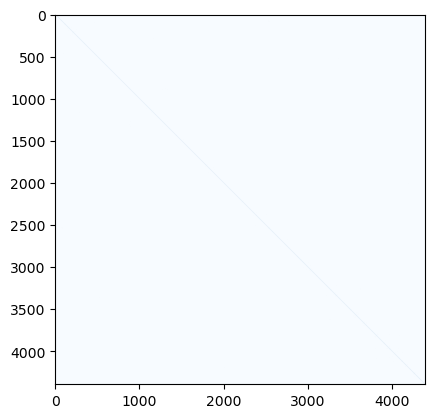

In [40]:
plt.imshow(similarity_mtx, cmap = 'Blues')

In [29]:
#recommend by matrix factorization
#item-item collaborative filtering model

def calculate_user_rating(userid, similarity_mtx, utility):
    user_rating = utility.loc[:,userid]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating


def recommendation_to_user(userid, top_n, similarity_mtx, utility):
    user_rating = utility.loc[:,userid]
    pred_rating = calculate_user_rating(userid, similarity_mtx, utility)

    top_item = sorted(range(1,len(pred_rating)), key = lambda i: -1*pred_rating.iloc[i])
    top_item = list(filter(lambda x: user_rating.iloc[x]==0, top_item))[:top_n]
    res = []
    for i in top_item:
        res.append(tuple([i, pred_rating.iloc[i]]))
    
    return res

In [33]:
recommendation_to_user(userid=sampled_df.user_id.iloc[3], 
                       top_n=10,
                       similarity_mtx=similarity_mtx,
                       utility=utility)

[(1, 5.0),
 (2, 5.0),
 (3, 5.0),
 (4, 5.0),
 (5, 5.0),
 (6, 5.0),
 (7, 5.0),
 (8, 5.0),
 (9, 5.0),
 (10, 5.0)]

In [41]:
res = calculate_user_rating(userid=sampled_df.user_id.iloc[21],
                            similarity_mtx=similarity_mtx,
                            utility=utility)
res

gmap_id
0x405c5a74b3440383:0xa36c9c1781e4be1f    5.0
0x405d7d631ff16add:0x9bed826678184414    5.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907    5.0
0x864819503264d297:0x2b4de82586d8bfef    5.0
0x89d312eb200a664f:0xb4bbc8c45ca9f926    5.0
                                        ... 
0x89fca77e3b810389:0x6a6bdb1acb82a3cf    5.0
0x89fca77e3c0f8823:0xa9ca279d40d03c03    5.0
0x89fca77e63bf1171:0xfe805276d1a642b7    5.0
0x89fca77e7dd46023:0x5a13b696296b8553    5.0
0x89fca7819984e3ef:0xe8cc9516b964edaa    5.0
Name: 1.1052638778170062e+20, Length: 4393, dtype: float64

In [46]:
top10_idx = np.argsort(res)[-10:][::-1]
res[top10_idx]

/var/folders/jw/fbxyh3ln4nx_m5d05tqlx_dc0000gp/T/ipykernel_27190/651765118.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res[top10_idx]


gmap_id
0x89fca7819984e3ef:0xe8cc9516b964edaa    5.0
0x89e3798da390661d:0x71ea14dd29ae0932    5.0
0x89e379885d2ef2ef:0x84f683f8b3137ed2    5.0
0x89e37988da768633:0xcc83151de2825e66    5.0
0x89e3798c3a0d3fe5:0x8c18306710bd474b    5.0
0x89e3798c3a0d3fe5:0x91daf2fa347c843a    5.0
0x89e3798c4b60a5b1:0x28e5f01cd1d9129     5.0
0x89e3798c4c81fa89:0x8837c1f86d03e749    5.0
0x89e3798da4b1bba3:0x47a45da2d697bab1    5.0
0x89e3796e9a273353:0x876ccd75c26a7563    5.0
Name: 1.1052638778170062e+20, dtype: float64

1) Take a subset of our dataset where the user-restaurant pair is more dense(Ex: Only users who have more than 20 reviews are kept)

2) Transform review texts into vectors using language model like BERT

3) Learn different variant of recommendation algorithm that can be applied to our project

4) Incorporate review vectors with other factors in the dataset into the recommendation algorithm

5) Find a reliable way to evaluate the performance of our recommendation algorithm

## Implementation Plan

1) Take a subset of our dataset where the user-restaurant pair is more dense(Ex: Only users who have more than 20 reviews are kept)

2) Transform review texts into vectors using language model like BERT

3) Learn different variant of recommendation algorithm that can be applied to our project

4) Incorporate review vectors with other factors in the dataset into the recommendation algorithm

5) Find a reliable way to evaluate the performance of our recommendation algorithm